In [1]:
import gpmultipy, scipy, json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear, Addition, Bias

In [3]:
def printSample(sample,depth=1):
    keys = sample.keys()
    keys.sort()
    
    for k in keys:
        if type(sample[k]) == dict:
            print "\t".join([""]*depth) + k
            printSample(sample[k],depth=depth+1)
        else:
            print "\t".join([""]*depth) + "%s: %s"%(k,str(sample[k]))

In [4]:
%matplotlib inline

In [33]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio='E')
y = np.log2(y)
y = y-y[0,:]
y = (y-y.mean())/y.std()

x = x + 1e-3

In [34]:
yKernel = White(1,.1)
k1 = RBF(1,1,1)
k2 = RBF(1,1,1)

p = y.shape[1]
dm = np.zeros((1+p,p))
dm[0,:] = 1
# dm[1:,1:] = 1
np.fill_diagonal(dm[1:,:],1)

prior = Prior(x,k1,[0])
prior2 = Prior(x,k2,range(1,dm.shape[0]))

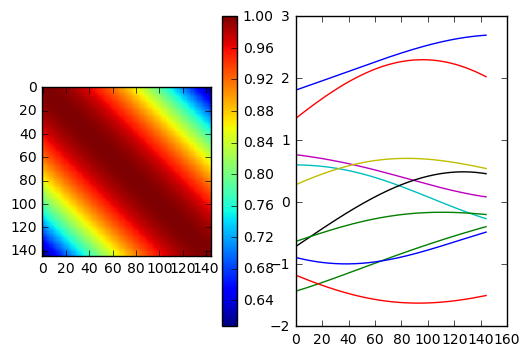

In [35]:
cov = k2.K(x)

plt.subplot(121)
plt.imshow(cov,interpolation='none')
plt.colorbar()

plt.subplot(122)
plt.plot(scipy.stats.multivariate_normal.rvs(prior2.mu,cov,size=10).T);

In [36]:
model = Model(x,y,dm)

In [37]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,sigma=x),
                    lambda x: scipy.stats.lognorm(1,scale=1e-0).logpdf(x),
                    .2,5,logspace=True)

kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2SigmaSlice = Slice('kSigma',
                    lambda x: prior2.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2LengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior2.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,k2=k2,model=model)

In [38]:
thin = 10
burnin = 0
nsample = 1000

for i in range(nsample):
    prior.sample(model,yKernel)
    prior2.sample(model,yKernel)
    
    yKernel.sigma = ySigmaSlice.sample(yKernel.sigma)
    
    k1.sigma = kSigmaSlice.sample(k1.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)
    
    k2.sigma = k2SigmaSlice.sample(k2.sigma)
    k2.lengthscale = k2LengthscaleSlice.sample(k2.lengthscale)

    if i % thin == 0 and i > burnin:
        f = freeze.freeze()
        del f['model']
        
        print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        print model.dataLikelihood(yKernel)
        printSample(f)
        print
        
        samples.append(freeze.freeze())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2987.00951231
k1
	lengthscale: 0.290140974176
	sigma: 7.55415801601
k2
	lengthscale: 0.288669259101
	sigma: 6.97684986501
yKernel
	sigma: 0.000896526013137

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3146.22780866
k1
	lengthscale: 0.204047602914
	sigma: 8.78673530555
k2
	lengthscale: 0.203275468418
	sigma: 8.60437832623
yKernel
	sigma: 0.000759962684072

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3171.86327386
k1
	lengthscale: 0.208205360232
	sigma: 6.9681547986
k2
	lengthscale: 0.19831795294
	sigma: 6.61018866657
yKernel
	sigma: 0.000724475121822

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3149.67533492
k1
	lengthscale: 0.212311435892
	sigma: 6.89141877071
k2
	lengthscale: 0.210847062787
	sigma: 7.32587781971
yKernel
	sigma: 0.00082477323769

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3168.98613801
k1
	lengthscale: 0.206638957283
	sigma: 7.22509327329
k2
	lengthscale: 0.200634725684
	sigma: 7.30405054846
yKernel
	sigma: 0.000803615488702

~~~~~~~~~~~~~~~~~~

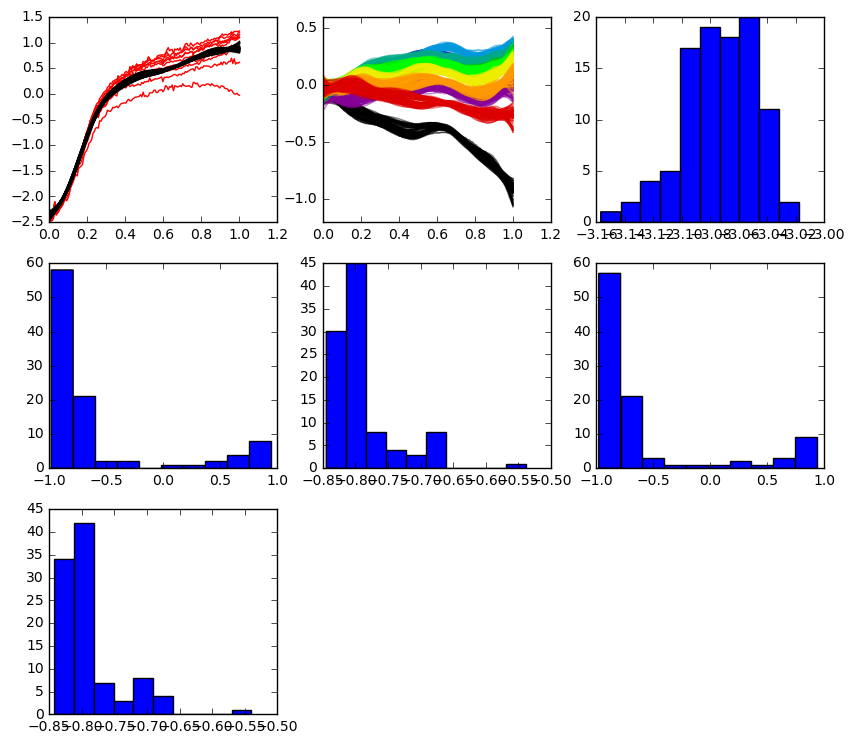

In [39]:
plt.figure(figsize=(10,9))
plt.subplot(331)
plt.plot(x,y,c='r')

# plt.subplot(232)
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='k',alpha=.5)

plt.subplot(332)

cmap = plt.get_cmap("spectral")
colors = [cmap(1.*i/p) for i in range(p)]
for i in range(p):
    plt.plot(x,np.array([s['model']['beta'][:,i+1] for s in samples]).T,c=colors[i],alpha=.5)

plt.subplot(333)
plt.hist(np.log10([s['yKernel']['sigma'] for s in samples]))

plt.subplot(334)
plt.hist(np.log10([s['k1']['sigma'] for s in samples]))

plt.subplot(335)
plt.hist(np.log10([s['k1']['lengthscale'] for s in samples]))

plt.subplot(336)
plt.hist(np.log10([s['k2']['sigma'] for s in samples]))

plt.subplot(337)
plt.hist(np.log10([s['k2']['lengthscale'] for s in samples]))

plt.savefig("figures/randomEffect-rbf-samples.pdf",bbox_inches='tight')

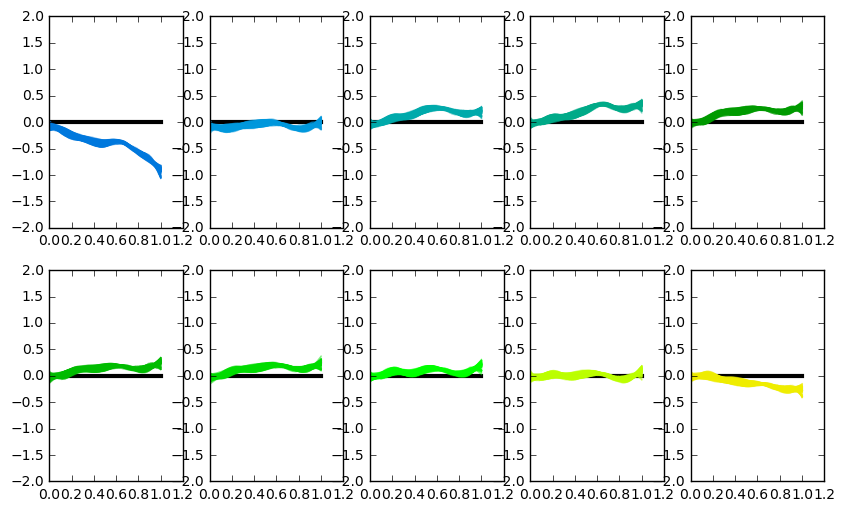

In [40]:
plt.figure(figsize=(10,6))

ncol = 5

cmap = plt.get_cmap("spectral")
colors = [cmap(1.*(i+5)/(p+10)) for i in range(p)]

for i in range(p):
    plt.subplot(p/ncol,ncol,i+1)
    
    plt.plot([x.min(),x.max()],[0,0],c='k',lw=3)
    plt.plot(x,np.array([s['model']['beta'][:,i+1] for s in samples[0:]]).T,c=colors[i],alpha=.5)
    
    plt.ylim(-2,2)

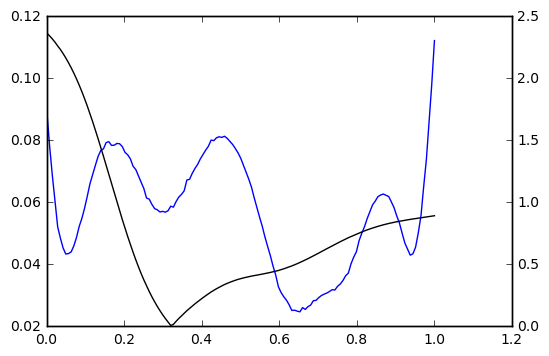

In [45]:
mu = np.array([s['model']['beta'][:,0] for s in samples]).T

plt.plot(x,mu.std(1)*2);

plt.twinx()
plt.plot(x,abs(mu.mean(1)),c='k');

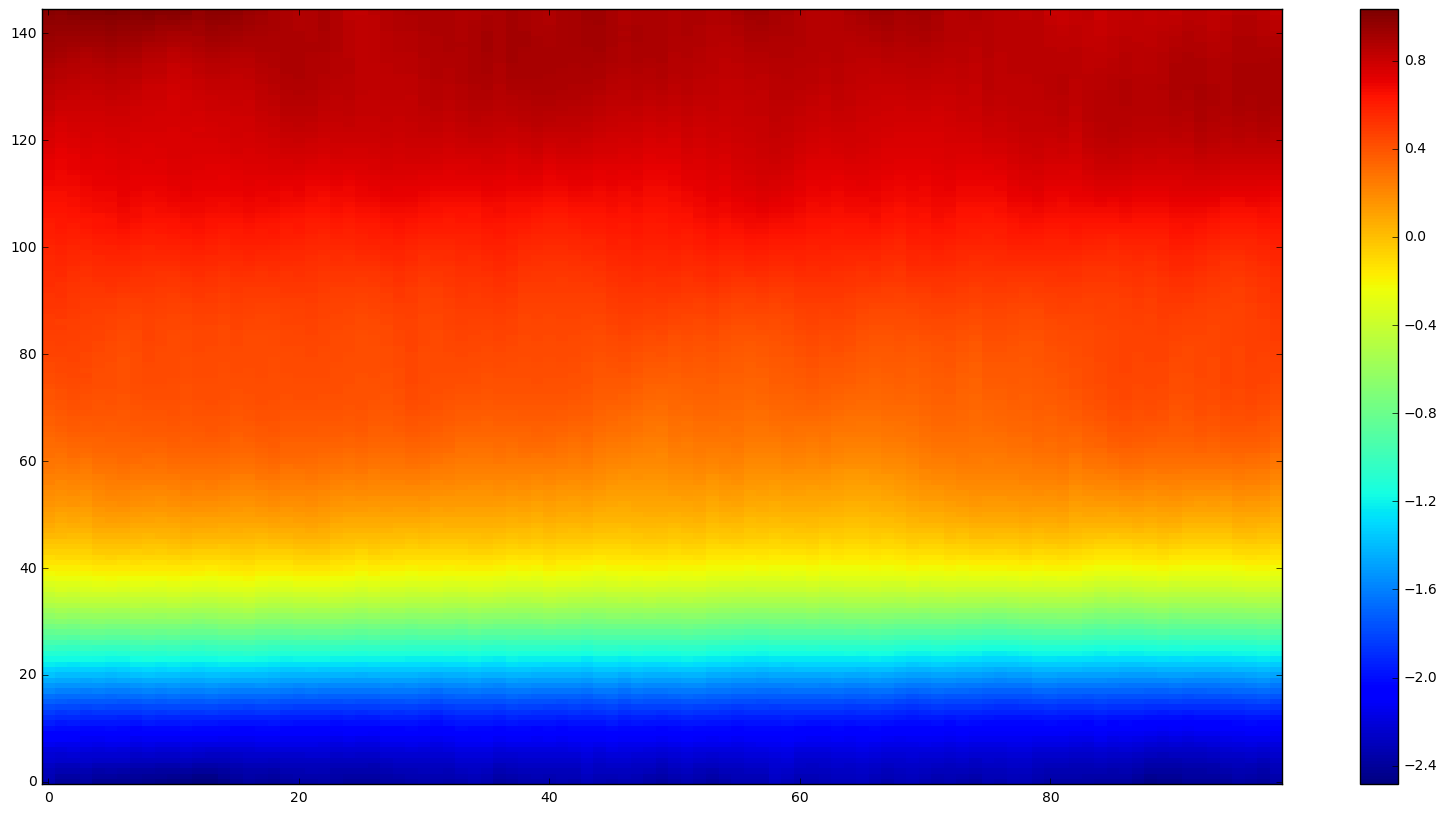

In [46]:
plt.figure(figsize=(20,10))
plt.imshow(mu,interpolation='none',origin='bottom',aspect='auto')
plt.colorbar()

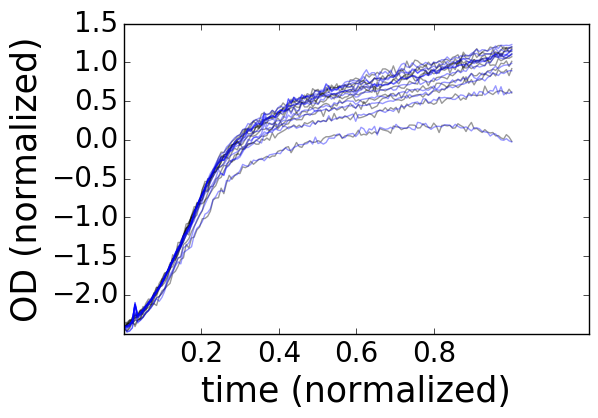

In [42]:
plt.figure(figsize=(6,4))

beta = samples[-1]['model']['beta']
mu = np.dot(beta,model.designMatrix).T
cov = yKernel.K(x)
ysample = mu + scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=model.r)

plt.plot(x[:,0],ysample.T,c='k',alpha=.4); 
plt.plot(x[:,0],y,c='b',alpha=.4); 
# plt.plot(x[:,0],fsample,c='r',lw=3);

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/model-randomEffect-generative-sameBeta.pdf",bbox_inches='tight',dpi=300)

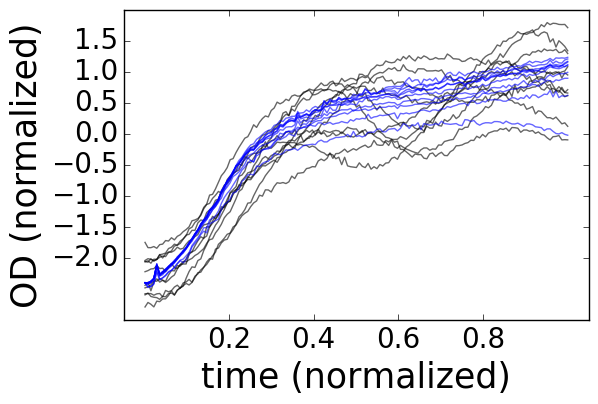

In [43]:
plt.figure(figsize=(6,4))

beta = samples[-1]['model']['beta']
cov = k2.K(x)
chol = gpmultipy.linalg.jitchol(cov)
cov = np.dot(chol,chol.T)

for i in range(1,beta.shape[1]):
    beta[:,i] = scipy.stats.multivariate_normal.rvs(prior2.mu,cov)

mu = np.dot(beta,model.designMatrix).T
cov = yKernel.K(x)
ysample = mu + scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=model.r)

plt.plot(x[:,0],ysample.T,c='k',alpha=.6); 
plt.plot(x[:,0],y,c='b',alpha=.6); 
# plt.plot(x[:,0],fsample,c='r',lw=3);

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)
plt.xlim(x.min()-x.max()*.05,x.max()*1.05)

plt.savefig("figures/model-randomEffect-generative-newBeta.pdf",bbox_inches='tight',dpi=300)

In [ ]:
ratio = [1.*s['k2']['k1']['k1']['sigma']/(s['k2']['k1']['k1']['sigma'] + s['k2']['k1']['k2']['sigma']) for s in samples]

plt.hist(ratio)
plt.title("$\sigma^2_{bias} / (\sigma^2_{bias} + \sigma^2_{linear})$")

In [ ]:
ratio = [1.*s['k2']['k2']['sigma']/(s['k2']['k2']['sigma']+ s['k2']['k1']['k1']['sigma'] + s['k2']['k1']['k2']['sigma']) for s in samples]

plt.hist(ratio)
plt.title("$\sigma^2_{RBF} / (\sigma^2_{RBF} + \sigma^2_{bias} + \sigma^2_{linear})$")

In [ ]:
cov = k2.K(x)

plt.subplot(121)
plt.imshow(cov,interpolation='none')
plt.colorbar()

plt.subplot(122)
plt.plot(scipy.stats.multivariate_normal.rvs(prior2.mu,cov,size=10).T);

In [ ]:
cov = k2.K(x)

plt.figure(figsize=())

plt.subplot(211)
sample = scipy.stats.multivariate_normal.rvs(prior2.mu,cov,size=10)

plt.plot(x,sample.T);
plt.xlim(x.min(),x.max())

plt.subplot(212)
plt.plot(x,np.sum(sample.T*sample.T,1));
plt.plot(x,np.sum(model.beta[:,1:]*model.beta[:,1:],1));
plt.xlim(x.min(),x.max())

In [ ]:
samplesCopy = [s for s in samples]
for s in samplesCopy:
    s['model']['beta'] = s['model']['beta'].tolist()

In [ ]:
s = json.dumps(samplesCopy)

In [ ]:
ofile = open("technical-replicate-randomRBF.json",'w')
ofile.write(s)
ofile.close()